**Computational Intelligence Homework**<br>
Frederik Darwin<br>
M10601836

**Initializing problem**

Maximize:
\begin{equation*}
f(x,y) = 8 -  \frac{sin^2(sqrt{(x^2+y^2)})} {(1+0.001*(x^2-y^2))^8} \quad-1 \le x \le 2; -1 \le y \le 1; x + y \ge -1
\end{equation*}

With $10^-3$ precision needed, x having 4 range will need 4000 vector, y with 3 range will need 3000 vector with separate chromosome

**12 bits needed for x and y both, totaling 24 bits**<br><br>
$2^{11} = 2048 <$ **3000, 4000** $< 2^{12} = 4096%$

With constraint $x+y \ge -1$ that will be looked at later

In [1]:
#importing libraries
import random as rnd
import math
import pandas as pd
import numpy as np
import functools
import itertools
import matplotlib.pyplot as plt

In [2]:
#defining number of generation, number of chromosome, etc
x_chro = 12
y_chro = 12
chromosome = x_chro + y_chro
generation = 200
population = 50
#tuning parameter
crossover_rate = 0.9
mutation_rate = 0.1

In [3]:
#defining binary to decimal number equation
def decimal(binary):
    dec = 0
    for i in range(len(binary)):
        if binary[i] == 1:
            dec = dec + 2**(11-i)
    return dec

def numberx(num):
    x = -1.0 + num*(3/(2**12-1))
    return format(x, '.3f')
    
def numbery(num):
    y = -1.0 + num*(2/(2**12-1))
    return format(y, '.3f')

In [4]:
#creating population
def randoming():
    test = []
    for i in range(population):
        test2 = []
        for j in range(chromosome):
            test2.append(round(rnd.random()))
        test.append(test2)
    return test

#genetic algorithm evaluation
def checkfitness(x, y):
    value = float(8 - ((math.sin((math.sqrt(float(x)**2+float(y)**2)))**2)/(1+0.001*(float(x)**2-float(y)**2))**8))
    return value

def printingrandom():
    val_column = []
    normal = []
    cumulation = []
    j = 0
    while j < int(population):
        a = randoming()
        x_binary = a[j][:x_chro]
        y_binary = a[j][x_chro:]
        x1 = decimal(x_binary)
        x11 = numberx(x1)
        y1 = decimal(y_binary)
        y11 = numbery(y1)
        #not allowing constraint
        if float(x11) + float(y11) >= -1:
            check = format(checkfitness(x11,y11), '.3f')
            #create new list for DataFrame column
            val_column.append(check)
            print("Chromosome " + str(j+1) + ":" + str([a[j]]) + "x = " + str(x11) + "  y = " + str(y11) + "  f(x,y) = " + str(check))
            j = j + 1
        else:
            j = j
        
    #creating DataFrame as a return function
    b = pd.DataFrame(a)
    b['f(x,y)'] = [float(i) for i in val_column]
    for i in range(population):
        normal.append(b['f(x,y)'][i]/sum(b['f(x,y)']))
    b['normalization'] = normal
    cum = 0
    for i in range(population):
        cumulation.append(cum + b['normalization'][i])
        cum = cum + b['normalization'][i]
    b['cumulation'] = cumulation
    
    
    return b

In [5]:
#next gen calculation
def xycalc(a):    
    fittesteachgen0 = []
    for i in range(generation-1):
        for j in range(population):
            fittest0 = 0
            x_binary = a[j+(i*int(population))][:x_chro]
            y_binary = a[j+(i*int(population))][x_chro:]
            x1 = decimal(x_binary)
            x11 = numberx(x1)
            y1 = decimal(y_binary)
            y11 = numbery(y1)
            check = format(checkfitness(x11,y11), '.3f')
            if fittest0 < float(check):
                fittest0 = float(check)
        fittesteachgen0.append(fittest0)
    return fittesteachgen0

In [6]:
#showing population and generation
def printgen1():
    gen = 1
    print("Generation #" + str(gen))
    df = printingrandom()
    return df

In [7]:
# selection, crossover, mutation
# I will make list of z from random that will determine 2 selection, 1 cross-over determinator,
# 1 cross-over point selection, and the rest will be bits-by-bits mutation
def selection():
    z = []
    for i in range(2+1+1+(population*chromosome)):
        z.append(rnd.random())
    #print(z)
    return z

In [8]:
#parent selection
def parents(df,dfcopy, select):
    parentslist = []
    for j in range(2):
        parent = min(df['cumulation'].tolist(), key=lambda x:abs(x-select[j]))
        for i in range(population):
            if parent == df['cumulation'][i]:
                #print("parent#" + str(j+1) +"= chromosome#" + str(i+1))
                parentslist.append(dfcopy[i][:])
    return parentslist

In [9]:
def crossoverdeterminator(df, b, select):
    thetwoparent = parents(df, b, select)
    crossover1 = select[2]
    crossover2 = select[3]
    temp_cross = []
    the_children = thetwoparent.copy()
    if crossover1 < crossover_rate:
        crossover3 = round(crossover2*chromosome)
        temp_cross.append(thetwoparent[0][crossover3:]) 
        temp_cross.append(thetwoparent[1][crossover3:])
        the_children[0][crossover3:] = temp_cross[1]
        the_children[1][crossover3:] = temp_cross[0]
#    else:
#        print("No crossovers made")
    return the_children

In [10]:
#mutation on the children
def mutation(df, b, select):
    children = crossoverdeterminator(df, b, select)
    for i in range(len(children)):
        for j in range(len(children[0])):
            if select[4+j] < mutation_rate:
                if children[i][j] == 0:
                    children [i][j] = 1
                else:
                    children [i][j] = 0
    return children

In [11]:
def generategeneration():
    #print first random generation
    df = printgen1()
    gen = 1
    #creating new dataframe to make a list from it
    b = df.copy()
    b.drop(['f(x,y)','normalization','cumulation'], axis=1, inplace=True)
    b = b.values.tolist()
    # c list stores generation
    c = []
    # fittest chromosome in generation 1
    fittesteachgen = [max(df['f(x,y)'])]
    for i in range(generation-1):
        #2 parents to make 2 children, so population/2
        
        #print("\nGeneration #" + str(gen+1))
        for j in range(int(population/2)):
            #create a random selection list
            selectionlist = selection()
            GeneticAlgorithm = mutation(df, b, selectionlist)      
            for k in range(len(GeneticAlgorithm)):
                c.append(GeneticAlgorithm[k])
            #print("\n")
        gen = gen+1
        #Generate a list of the fittest chromosome in the next generation   
        
    return df, c, fittesteachgen

In [12]:
firstgen, secgen, fittest = generategeneration()
a = xycalc(secgen)
fittestall = fittest + a






Generation #1
Chromosome 1:[[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]]x = 1.462  y = 0.405  f(x,y) = 7.018
Chromosome 2:[[0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1]]x = -0.259  y = -0.462  f(x,y) = 7.744
Chromosome 3:[[0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0]]x = -0.386  y = 0.640  f(x,y) = 7.537
Chromosome 4:[[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]]x = 0.314  y = 0.618  f(x,y) = 7.591
Chromosome 5:[[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0]]x = -0.347  y = -0.547  f(x,y) = 7.635
Chromosome 6:[[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]]x = -0.064  y = 0.779  f(x,y) = 7.501
Chromosome 7:[[1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]]x = 0.799  y = 0.711  f(x,y) = 7.232
Chromosome 8:[[1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1]]x = 1.667  y = 0.288  f(x

In [13]:
firstgen.sort_values(by=['f(x,y)'], ascending = False)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,"f(x,y)",normalization,cumulation
14,0,0,0,0,1,1,1,1,0,1,...,1,1,1,0,1,1,0,7.992,0.021547,0.301448
17,0,0,1,0,0,0,1,1,1,1,...,1,0,1,1,0,0,1,7.953,0.021442,0.363838
31,0,0,0,1,1,0,0,0,1,1,...,1,0,0,1,0,1,0,7.889,0.021269,0.641533
22,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,1,0,7.887,0.021264,0.462272
10,0,0,1,0,0,0,0,1,0,0,...,1,1,0,0,1,0,0,7.838,0.021132,0.219020
38,0,1,0,1,0,1,0,0,0,1,...,0,1,0,1,0,0,0,7.810,0.021056,0.780632
43,0,1,0,0,1,0,0,0,1,0,...,1,0,0,1,1,0,1,7.799,0.021027,0.880024
23,1,1,0,0,1,0,1,0,0,0,...,1,1,0,1,1,0,1,7.750,0.020895,0.483167
45,0,1,0,0,0,1,1,0,1,0,...,0,0,0,0,1,1,1,7.746,0.020884,0.920549
1,1,0,1,1,1,1,0,1,0,0,...,0,0,0,0,1,1,1,7.744,0.020879,0.039800


In [14]:
fittestall

[7.992,
 7.511,
 7.159,
 7.802,
 7.498,
 7.634,
 7.639,
 7.663,
 7.119,
 7.071,
 7.228,
 7.054,
 7.58,
 7.915,
 7.589,
 7.308,
 7.238,
 7.47,
 7.376,
 7.76,
 7.282,
 7.956,
 7.193,
 7.737,
 7.623,
 7.103,
 7.621,
 7.633,
 7.364,
 7.131,
 7.36,
 7.033,
 7.632,
 7.264,
 7.232,
 7.215,
 7.482,
 7.158,
 7.346,
 7.629,
 7.369,
 7.338,
 7.25,
 7.937,
 7.412,
 7.301,
 7.983,
 7.296,
 7.119,
 7.741,
 7.325,
 7.287,
 7.445,
 7.461,
 7.384,
 7.247,
 7.171,
 7.752,
 7.239,
 7.034,
 7.209,
 7.409,
 7.464,
 7.681,
 7.768,
 7.555,
 7.323,
 7.324,
 7.218,
 7.232,
 7.732,
 7.294,
 7.517,
 7.12,
 7.064,
 7.134,
 7.223,
 7.301,
 7.064,
 7.162,
 7.453,
 7.358,
 7.648,
 7.019,
 7.968,
 7.531,
 7.869,
 7.514,
 7.078,
 7.653,
 7.524,
 7.326,
 7.998,
 7.136,
 7.995,
 7.595,
 7.975,
 7.3,
 7.537,
 7.924,
 7.464,
 7.088,
 7.281,
 7.908,
 7.442,
 7.059,
 7.453,
 7.389,
 7.18,
 7.545,
 7.048,
 7.343,
 7.459,
 7.202,
 7.114,
 7.647,
 7.061,
 7.131,
 7.228,
 7.958,
 7.126,
 7.874,
 7.887,
 7.07,
 7.052,
 7.451,
 7

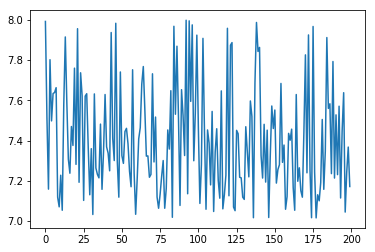

In [15]:
#creating graph to see convergence (only taking most fittest of the population per generation)
plt.plot(fittestall)